In [1]:
#GPU
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

NVIDIA A100-SXM4-40GB, 40960 MiB, 40511 MiB



# **Modern Convolutional Neural Networks (ResNeXt-18)**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Residual Block

In [3]:
# Defines the Conv2D layer outside the Residual and ResnetBlock classes
conv2d_layer = tf.keras.layers.Conv2D(64, kernel_size=1, strides=1, padding='same')

In [4]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same', kernel_size=3, strides=strides, groups=32)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same', groups=32)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

        if use_1x1conv or strides != 1:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides, padding='same')
        else:
            self.conv3 = None

        # Pre-emptively creating a 1x1 convolution layer for adjusting dimensions
        # This layer will be used only if the shapes of inputs and the output of conv2 do not match
        self.dim_adjust = tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=1, padding='same')

    def call(self, inputs):
        Y = self.conv1(inputs)
        Y = self.bn1(Y)
        Y = self.relu(Y)

        Y = self.conv2(Y)
        Y = self.bn2(Y)

        if self.conv3 is not None:
            inputs = self.conv3(inputs)
        else:
            # Using the pre-created layer for dimension adjustment if necessary
            if inputs.shape[-1] != Y.shape[-1]:
                inputs = self.dim_adjust(inputs)

        Y += inputs
        return self.relu(Y)

# ResNeXt Model

In [5]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels)) #,  use_1x1conv=True

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X


In [6]:
b2 = ResnetBlock(128, 3, first_block=True)
b3 = ResnetBlock(256, 4)
b4 = ResnetBlock(512, 6)
b5 = ResnetBlock(1024, 3)

In [7]:
def net():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(96,96,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # Dropout layer added
        tf.keras.layers.Dropout(0.5),
        # The following layers are the same as b2, b3, b4, and b5 that was created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer=tf.optimizers.Adam(learning_rate=1e-4)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

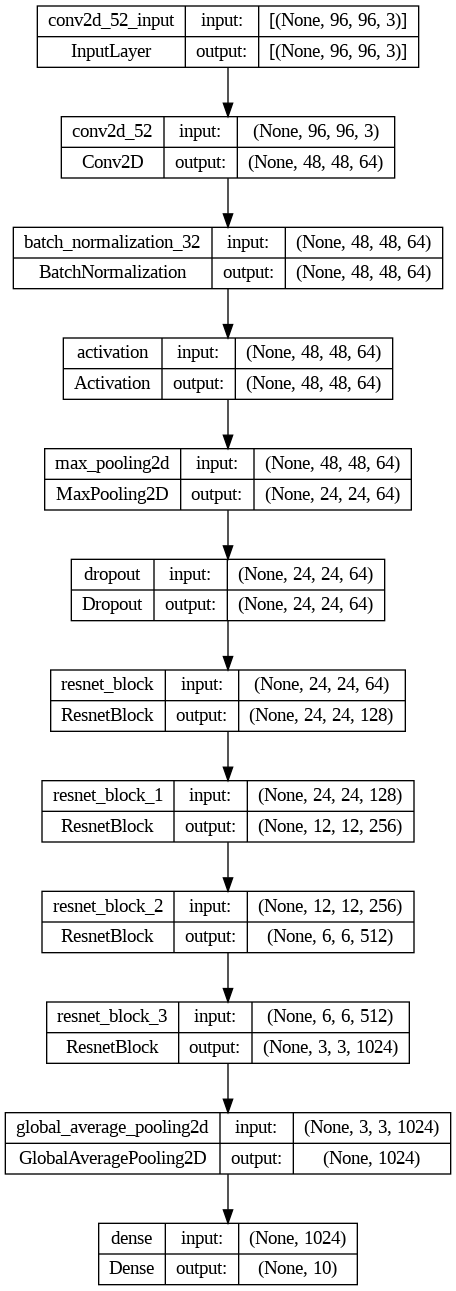

In [8]:
model = net()
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 48, 48, 64)        9472      
                                                                 
 batch_normalization_32 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 resnet_block (ResnetBlock)  (None, 24, 24, 128)       3

# **Training**

# Load the data

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


def process_images(image, label):
    # Resize images from 32x32 to 96x96
    image = tf.image.resize(image, (96,96))
    return image, label




train_dataset = (train_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))
test_dataset = (test_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))

In [11]:
# Get the first batch of data from the training dataset
batch_x, batch_y = next(iter(train_dataset))

# Predict the output of the model on the first batch of data
model_output = model(batch_x)

# Print the shapes of the input and output
print(f"Input shape: {batch_x.shape}")
print(f"Output shape: {model_output.shape}")

Input shape: (32, 96, 96, 3)
Output shape: (32, 10)


In [12]:
history = model.fit(train_dataset,
            epochs=50,
            validation_data=test_dataset)

Epoch 1/50
1562/1562 [==============================] - 67s 31ms/step - loss: 1.6729 - accuracy: 0.3959 - val_loss: 2.0292 - val_accuracy: 0.3397
Epoch 2/50
1562/1562 [==============================] - 45s 29ms/step - loss: 1.2717 - accuracy: 0.5461 - val_loss: 1.6685 - val_accuracy: 0.4499
Epoch 3/50
1562/1562 [==============================] - 45s 29ms/step - loss: 1.0692 - accuracy: 0.6224 - val_loss: 1.2340 - val_accuracy: 0.5756
Epoch 4/50
1562/1562 [==============================] - 45s 29ms/step - loss: 0.9198 - accuracy: 0.6778 - val_loss: 1.2818 - val_accuracy: 0.5791
Epoch 5/50
1562/1562 [==============================] - 45s 29ms/step - loss: 0.7865 - accuracy: 0.7222 - val_loss: 1.4949 - val_accuracy: 0.5393
Epoch 6/50
1562/1562 [==============================] - 45s 29ms/step - loss: 0.6656 - accuracy: 0.7676 - val_loss: 1.4092 - val_accuracy: 0.5775
Epoch 7/50
1562/1562 [==============================] - 45s 29ms/step - loss: 0.5425 - accuracy: 0.8099 - val_loss: 1.4469 -

# Visualize the training and validation accuracy

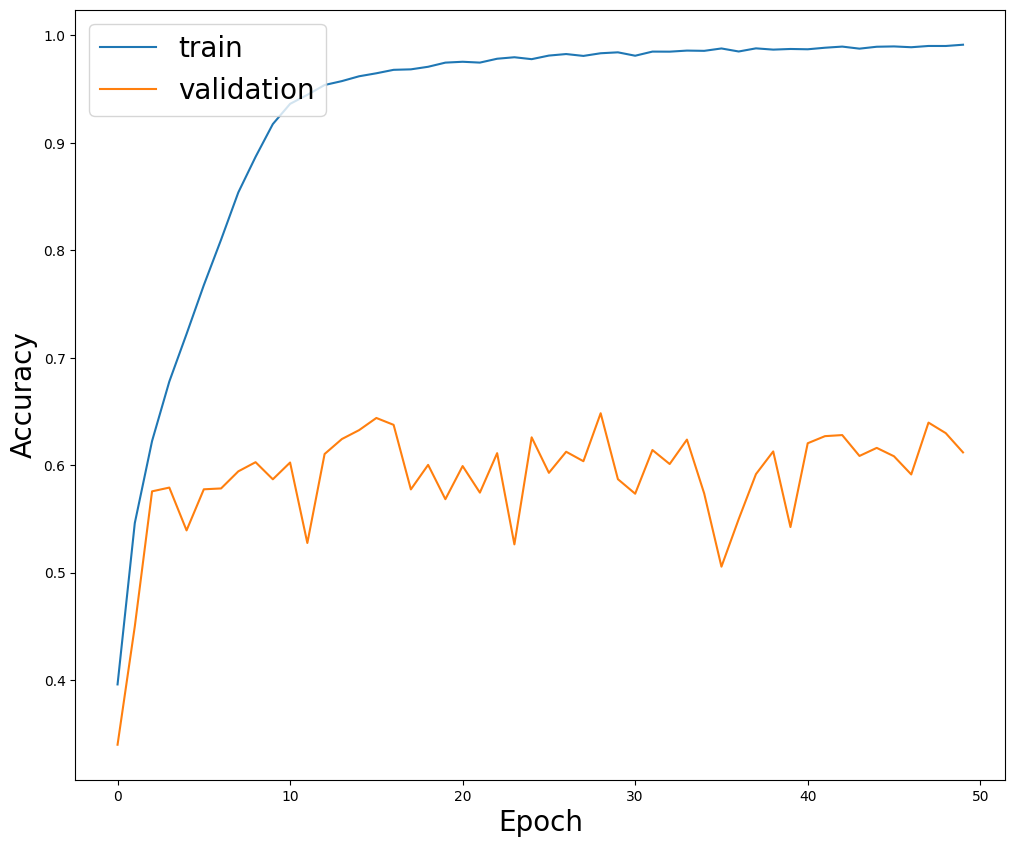

In [13]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

# Evaluate the trained model

In [14]:
score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.6210408210754395
Test accuracy: 0.6118789911270142


# Predict using the trained model

1/1 [==============================] - 0s 24ms/step


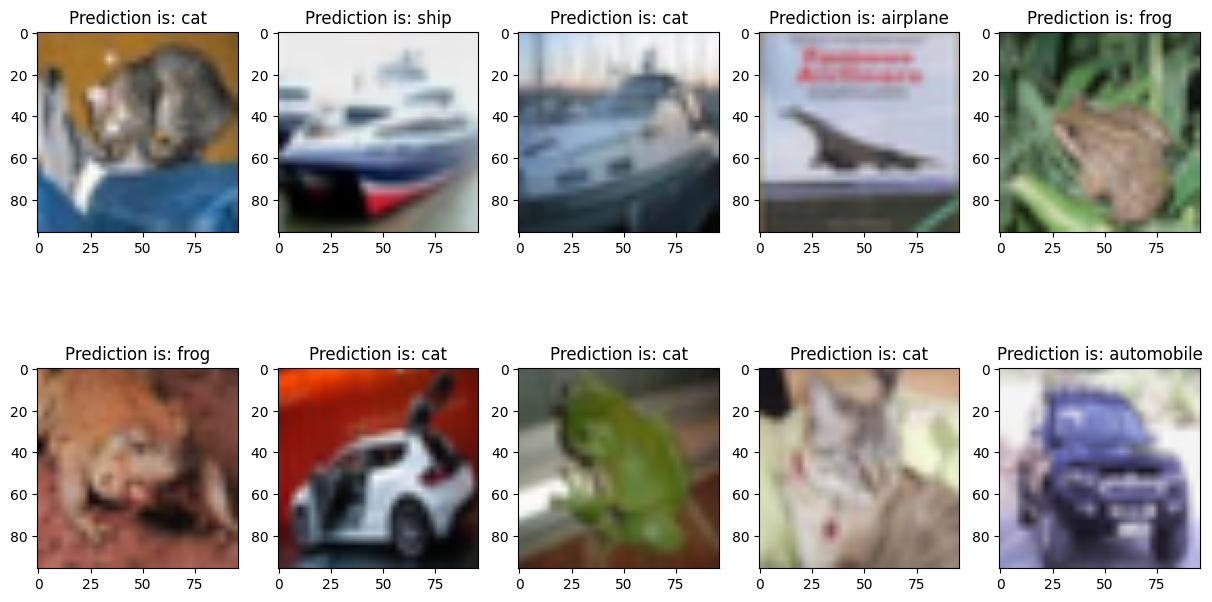

In [15]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()

# Predicts the last 10 images
for i, (image, label) in enumerate(test_dataset.take(1)):
    for i in range(10):
      ax[i].imshow(image[i])
      ax[i].set_title("Prediction is: {}".format(CLASS_NAMES[model.predict(np.reshape(image[i], (1,96,96,3))).argmax()]), fontsize=12)